# Entangled Conditional Adversarial Autoencoder for de Novo Drug Discovery

## Method
Supervised Adversarial Autoencoder은 generative model 중 하나로, GAN과 conditional Autoencoder를 합쳐놓은 것인 Adversarial Autoencoder의 발전된 형태라고 보면 된다. Autoencoder, discriminator두 가지 파트로 나눌 수 있다. 구조가 거의 비슷한 SAAE의 배경이 되는 Adversarial Autoencoder(AAE)를 살펴본 후에 SAAE에 대해 알아보도록 하자.

Autoencoder 부분인 위쪽 부분은 일반적인 autoencoder의 구조와 동일하다. Input $x$가 encoder $E$를 통해 latent vector $z$가 되고, 이것이 decoder $G$를 통해 $x$와 최대한 비슷한 $x'$이 되도록 만들어지는 것이다. 특정 prior vector를 condition으로 하여, discriminator가 prior $p(z)$와 latent distribution $q(z)$를 구분하도록 학습을 시키고, encoder $E$는 discriminaotr가 latent를 잘 구분하지 못하도록 latent를 만들어내는 역할을 한다. AAE에서는 encoder가 GAN model의 generator의 역할을 하고 있는 셈이다. Adversarial training을 포함한 autoencoder이기 때문에 optimization task는 generative model의 loss function과 autoencoder의 reconstruction loss를 합하여 아래의 식처럼 표현되는 loss function의 minimax game 형태이다.

$\qquad min_{E,G} max_D L_{adv}$
$$= min_{E,G} max_D E_{x \sim p_{data}} log D(E(x)) + E_{z \sim p_{(z)}} log (1 - D(z)) - E_{x \sim p_{data}} log p(x|G(E(x)))$$
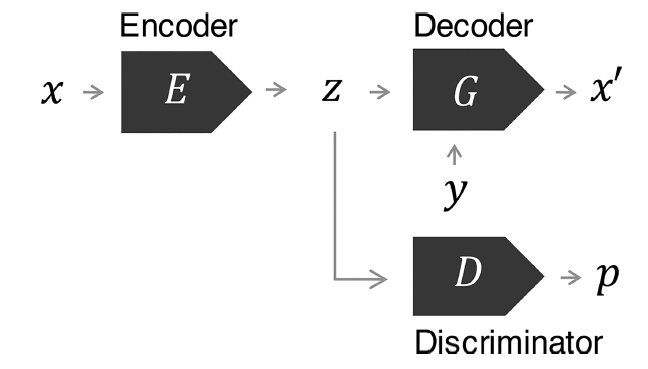
SAAE는 reconstruction 과정$(G(z) \rightarrow x')$에서 분자의 물성 $y$와 latent vector $z$를 concatenate한 것을 input으로 넣는다. 물성을 넣어서 decoder를 거칠 때의 optimization task는 위 식의 마지막 항에서 decoder $G$를 거칠 때 latent vector $z$와 물성 $y$가 모두 영향을 미치도록 다음과 같이 바뀐다.

$$min_{E,G} max_D E_{x \sim p_{data}} log D(E(x)) + E_{z \sim p_{(z)}} log (1 - D(z)) - E_{x \sim p_{data}} log p(x|G(E(x, \boldsymbol y)))$$

기존의 논문에서는 새로운 것을 $z$를 sampling하고, condition 조건을 추가해준 것을 generator에 넣었다. 이렇게 할 경우 분자의 구조 등을 나타내는 $z$와 새로운 condition 사이에 연관성이 없게 된다. 

### Disentanglement of Z and Y
Latent code $z$와 properties $y$를 분리시키는 방법에 대한 내용이다.
#### Predictive Disentanglement
Latent code $z$로부터 properties $y$를 얻어내고, latent code로부터 얻어낸 feature들을 제거하는 방식으로 neural net을 학습시키는 방법이다. 
#### Joint Disentanglement
$q(E(x), y)$를 $p(z)p(y)$로 근사시킴으로써 $z$와 $y$의 관계를 없애는 방법이다.  

두 가지 방법을 같이 사용하였을 때, predictive disentanglement는 $p(y_i|z) = p(y_i)$가 되도록 하였고, joint disentanglement는 나머지 정보들을 제거해주는 역할을 하였다. 결론적으로 좀 더 stable하고 나은 결과를 얻게 되었다. 이를 combined disentanglement라고 한다.

$$min_{E,G} max_D E_{x \sim p_{data}} log D(E(x)) + E_{z \sim p_{(z)}} log (1 - D(z)) - E_{x \sim p_{data}} log p(x|G(E(x, \boldsymbol y))) + \lambda E_{(x,y) \sim p_{data}} log q(y|E(x))$$

Label과 latent code의 disentanglement는 좋은 기술이지만, latent feature들을 제대로 해석하지 못하게 될 수도 있다는 한계점이 있다. 예를 들어 이미지 처리에서 고양이와 차라는 클래스가 달라짐에 따라 색의 분포도가 차이가 있는 것처럼 class에 대한 정보가 아무것도 없다면 분석하기 쉽지 않다. 따라서 latent code의 구조를 개선하기 위해서는 $y$와 $z$의 연관성이 어느정도 필요하다. 이러한 연관성을 가지게 하기 위해서 처음에 데이터 $x$를 받고난 후에 encoder를 통해 latnet code $z$로 만든 후, 그것을 reparamatize 시켜 normal distribution 형태로 만들어낸다.($p(z|y) = N(z|\mu_\theta (y), \sigma_\theta (y))$, with $\theta$ optimized during training) 그리고 그것을 더하거나 하는 등의 reparamatization trick을 거쳐 $\bar{z}$를 만들어내고 거기에 disentanglement techniques를 적용한다. 즉 우리가 원하는 성질만 가지고, 원치 않는 성질들은 latent로 부터 배제할 수 있도록 하는 것이다. 이 모델을 Entangled Conditional Adversarial Autoencoder(ECAAE)이라고 칭한다.

we introduced an ECAAE with several disentanglement
techniques to improve the generation quality. We
applied our model to a generation of molecules with specified
property descriptors, solubility, and synthetic accessibility
scores. We also conditioned the model on target-specific
properties, such as the binding energy or IC50. ECAAE discovered
a promising hit compound with high selectivity against
the JAK3 isoform over JAK2 and RAF kinases. The proposed
architecture can be used to generate novel molecules with promising
scaffolds. These results suggest that ECAAE can be integrated
into the automated drug discovery pipelines to generate
large sets of initial hypotheses for drugs in multiple disease areas.

Let's say the following vectors are respectively representations for a ball: [1,0,0,0] and a car: [0,1,0,0]

In this representation a single neuron learns the meaning of a ball or a car without having to rely on other neurons. This is a disentangled representation, which is meant to facilitate the understanding of artificial neural networks.

This in contrast to distributed representations, for example, a ball: [0.1,-0.02,0.45,0.06] and a car: [-0.78,-0.1,0.83,0.01]. In this case, an object is represented by a particular location in the vector space. This type of representation is for example the outcome of the word2vec algorithms.